#  Diagrammatic Differentiation in Practice

Slides from the Oxford quantum group lunch talk on February 18th 2021.

## Implementing automatic differentiation in discopy

In [1]:
from discopy import *
from discopy.quantum import *
from discopy.quantum.zx import Functor, Diagram

from sympy.abc import theta, phi, symbols
from matplotlib import pyplot as plt

**Derivatives are compositional**: if you have the derivative of each box, then you have the derivative of the diagrams made from those boxes.

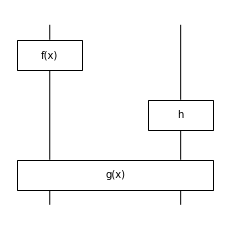

In [2]:
x = symbols('x')

f_array = [[1, 0], [0, x]]
g_array = [[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,x*x]]
h_array = [[1, 1], [1,-1]]

f = QuantumGate('f(x)', n_qubits=1, data=x, array=f_array)
g = QuantumGate('g(x)', n_qubits=2, data=x, array=g_array)
h = QuantumGate('h', n_qubits=1, data=None, array=h_array)

d = {f: [[0, 0], [0, 1]], g: [[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,2*x]]}

circuit = (f @ h >> g)
circuit.draw(figsize=(3,3))

Given a commutative rig $\mathbb{S}$, a derivation $\partial: \mathbb{S} \rightarrow \mathbb{S}$ is defined as any operation that satisfies the linearity and product rules:

$$ \partial(f + g) = \partial f + \partial g \quad \text{and} \quad \partial(f \times g) = \partial f \times g + f \times \partial g $$

A related notation is dual numbers $D[\mathbb{S}]$, numbers of the form $a + b \epsilon$ for $a, b \in \mathbb{S}$ such that $\epsilon^2 = 0$. Sum and product are given by:

\begin{aligned}
\left(a+a^{\prime} \epsilon\right)+\left(b+b^{\prime} \epsilon\right) &=(a+b)+\left(a+b^{\prime}\right) \epsilon \\
\left(a+a^{\prime} \epsilon\right) \times\left(b+b^{\prime} \epsilon\right) &=(a \times b)+\left(a \times b^{\prime}+a^{\prime} \times b\right) \epsilon
\end{aligned}

Write $\pi_0, \pi_1 : D[\mathbb{S}] \to \mathbb{S}$ for the projections along the real and epsilon component resp.

**Lemma:** Every derivation defines a rig homomorphism $\mathbb{S} \to D[\mathbb{S}]$ with $f \mapsto f + \partial f$. The other way around, every a rig homomorphism $\partial : \mathbb{S} \to D[\mathbb{S}]$ with $\pi_0 \circ \partial = \text{id}_\mathbb{S}$ defines a derivation $\pi_1 \circ \partial : \mathbb{S} \to \mathbb{S}$.

For example, in the rig of smooth functions we can lift any
smooth function $f : \mathbb{R} \rightarrow \mathbb{R}$ to a function $f: D[\mathbb{R}] \rightarrow D[\mathbb{R}]$ over the dual numbers defined by:

$$f\left(a+a^{\prime} \epsilon\right)=f(a)+a^{\prime} \times(\partial f)(a) \epsilon$$

Then we can derive the following linearity, product and chain rules:

\begin{aligned}
(f+g)\left(a+a^{\prime} \epsilon\right) &=(f+g)(a)+a^{\prime} \times(\partial f+\partial g)(a) \epsilon \\
(f \times g)\left(a+a^{\prime} \epsilon\right) &=(f \times g)(a)+a^{\prime} \times(f \times \partial g+\partial f \times g)(a) \epsilon \\
(f \circ g)\left(a+a^{\prime} \epsilon\right) &=(f \circ g)(a)+a^{\prime} \times(\partial g \times \partial f \circ g)(a) \epsilon
\end{aligned}


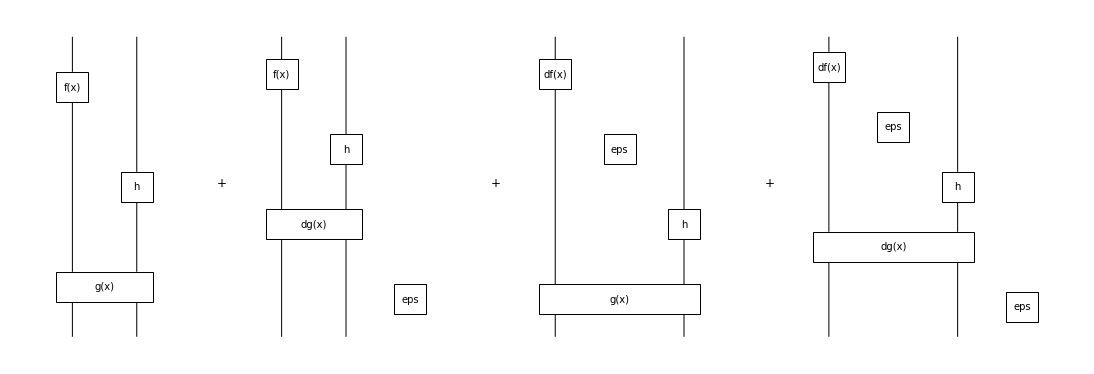

In [3]:
eps = QuantumGate('eps', n_qubits=0, array=[1e-10])

def DualFunctorAr(box):
    if x in box.free_symbols:
        d_box = QuantumGate(f'd{box.name}', n_qubits=len(box.cod), data=x, array=d[box])
        return box + d_box @ eps
    else:
        return box
    
dual_functor = CircuitFunctor(ob=lambda x: x,  ar=DualFunctorAr)
test = dual_functor(circuit)
test.draw(figsize=(15, 5))

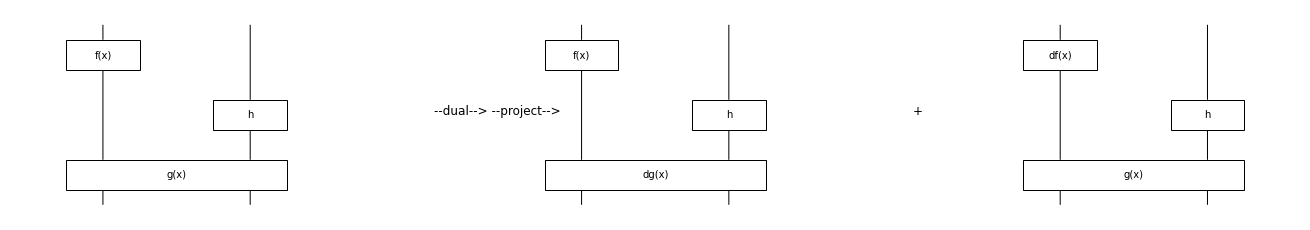

In [4]:
def project_in_eps(diagram):
    eps_terms = []
    for term in diagram.terms:
        if [box.name for box in term.boxes].count('eps') == 1:
            # remove epsilon
            remove_eps_functor = CircuitFunctor(ob=lambda x: x,
                                                ar=lambda x: Id(0) if x.name == 'eps' else x)
            eps_term = remove_eps_functor(term)
            eps_terms.append(eps_term)
    return Sum(eps_terms, cod=diagram.cod, dom=diagram.dom)
    
drawing.equation(circuit,
                  project_in_eps(test), figsize=(18, 3), symbol="--dual--> --project-->")

$$\tiny
(f(x) \otimes h) \circ g =
\left(\begin{pmatrix}1 & 0 \\ 0 & x\end{pmatrix} \otimes
\begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}\right) \circ
\begin{pmatrix}1&&&\\&1&&\\&&1&\\&&&x^2\end{pmatrix} =
\begin{pmatrix}1&1&&\\1&-1&&\\&&x&x^3\\&&x&-x^3\end{pmatrix}
$$

In [5]:
project_in_eps(test).eval().array.reshape(4, 4)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1.00000000000000, 3.0*x**2],
       [0, 0, 1.00000000000000, -3.0*x**2]], dtype=object)

## Rules for diffentiating diagrams

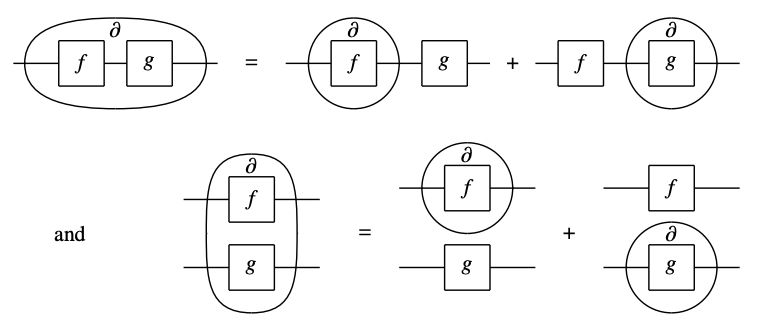

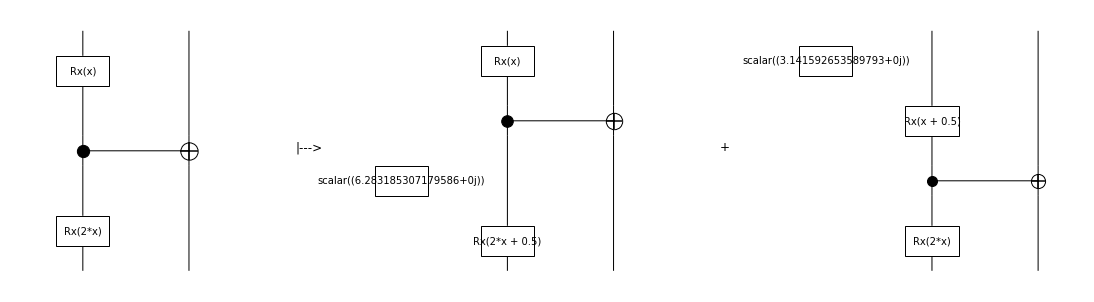

In [6]:
circuit = (Rx(x) @ Id(1)) >> CX >> (Rx(2*x) @ Id(1))
drawing.equation(circuit, circuit.grad(x, mixed=False), symbol='|--->', figsize=(15, 4))

## Rules for differentiating ZX diagrams

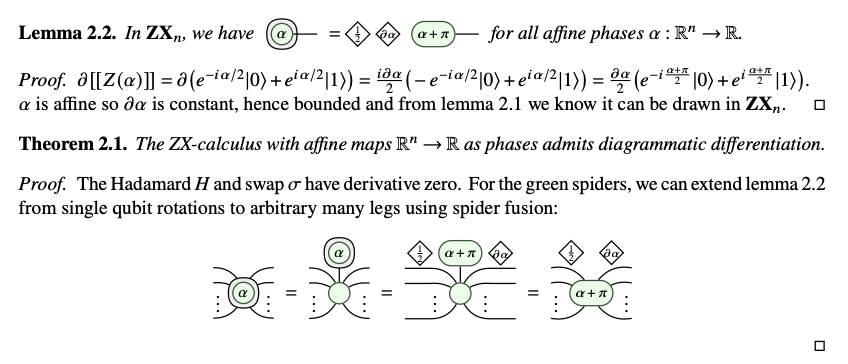

In [7]:
XC = QuantumGate('XC', n_qubits=2, array=[[0,1,0,0], [1,0,0,0],[0,0,1,0], [0,0,0,1]])

def gate2zx_new(box):
    from discopy.quantum.zx import gate2zx, PRO, Z, X, Id
    if box == XC:
        return Id(1) @ Z(1, 2) >> X(2, 1) @ Id(1)
    else:
        return gate2zx(box)
circuit2zx = Functor(ob={qubit: PRO(1)}, ar=gate2zx_new, ob_factory=PRO, ar_factory=Diagram)

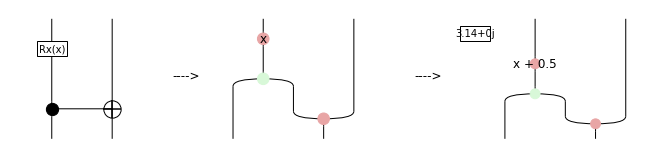

In [8]:
circuit = (Rx(x) @ Id(1)) >> CX
drawing.equation(circuit, circuit2zx(circuit), circuit2zx(circuit).grad(x), figsize=(9, 2), symbol="---->")

## Doubling via the CPM construction

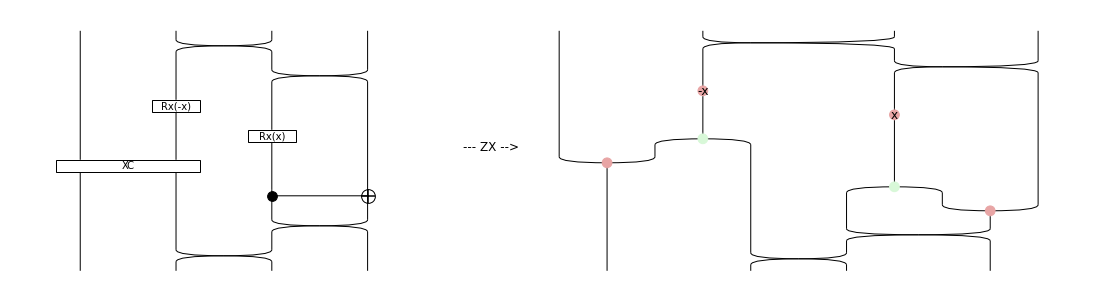

In [9]:
swaps = Id(2) @ SWAP >> Id(1) @ SWAP @ Id(1)
doubled_circuit = swaps[::-1] >> Id(1) @ Rx(-x) @ Rx(x) @ Id(1) >> XC @ CX >> swaps
drawing.equation(doubled_circuit, circuit2zx(doubled_circuit), symbol="--- ZX -->", figsize=(15, 4))

Both `Circuit`s and `zx.Diagram`s can be differentiated.

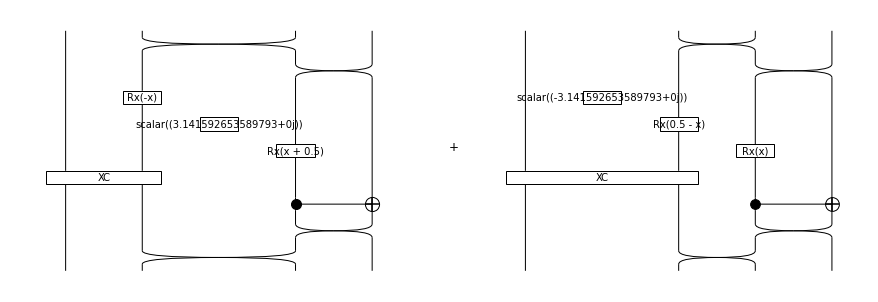

In [10]:
doubled_circuit.grad(x, mixed=False).draw(figsize=(12, 4))

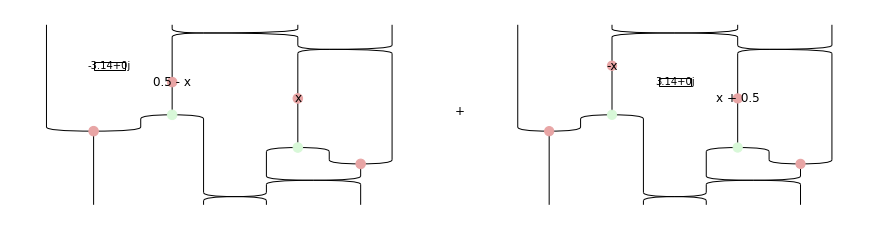

In [11]:
circuit2zx(doubled_circuit).grad(x).draw(figsize=(12, 3))

Differentiating a circuit as doubled diagram can give you an asymmetric, undoubled diagram due to the product rule.
These diagrams cannot be executed on quantum hardware. 

## Differntiating Circuits
Similar to how we defined the derivatives of the ZX `Spider`s in terms of `Spiders`, the generators of ZX, we need to define the derivatives of the parameterised `QuantumGate`s in terms of `QuantumGate`s

From Schuld et al. the parameter-shift rule for `Rz` is given by
$\partial R_z(\theta) = \frac{1}{2} [R_z(\theta + \frac{\pi}{2}) - R_z(\theta - \frac{\pi}{2})]$

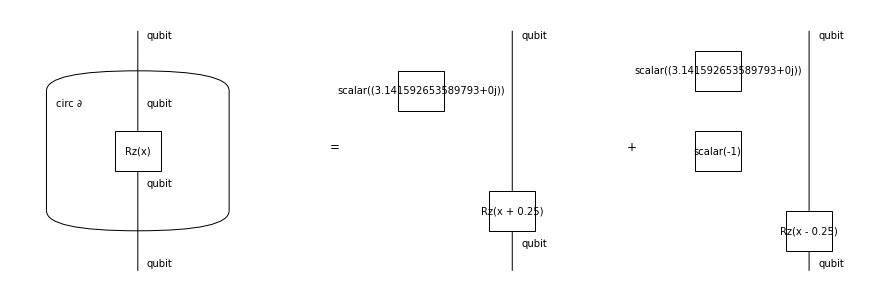

In [12]:
drawing.equation(Rz(x).bubble(drawing_name="circ ∂"),
                 Rz(x).grad(x), figsize=(12, 4))

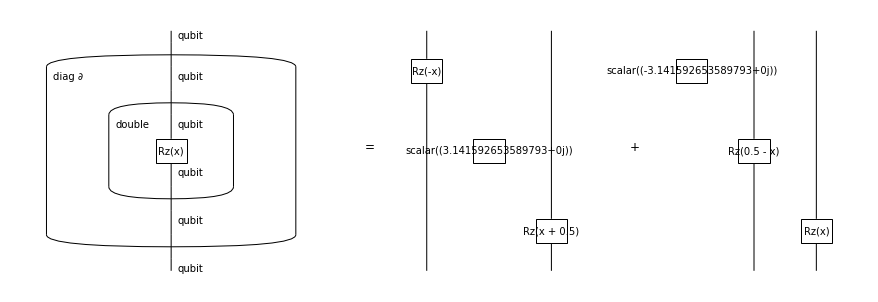

In [13]:
drawing.equation(Rz(x).bubble(drawing_name="double").bubble(drawing_name="diag ∂"),
                 (Rz(-x) @ Rz(x)).grad(x, mixed=False), figsize=(12, 4))

Bear in mind that the previous equation is an equation on circuits, and the this one is an equation on linear maps.

## Checks for Diagrams
we checked that the diagrammatic derivatives equals the derivatives of sympy.

In [14]:
import numpy as np
def _to_square_mat(m):
    m = np.asarray(m).flatten()
    return m.reshape(2 * (int(np.sqrt(len(m))), ))

def test_rot_grad():
    from sympy.abc import phi
    import sympy as sy
    for gate in (Rx, Ry, Rz, CU1, CRx, CRz):
        # Compare the grad discopy vs sympy
        op = gate(phi)
        d_op_sym = sy.Matrix(_to_square_mat(op.eval().array)).diff(phi)
        d_op_disco = sy.Matrix(
            _to_square_mat(op.grad(phi, mixed=False).eval().array))
        diff = sy.simplify(d_op_disco - d_op_sym).evalf()
        assert np.isclose(float(diff.norm()), 0.)

test_rot_grad()

## Checks for Circuits
we checked that the circuit derivative on the circuit is equal to the diagrammatic derivative of the doubled diagram.

In [15]:
def test_rot_grad_mixed():
    from sympy.abc import symbols
    from sympy import Matrix

    z = symbols('z', real=True)
    random_values = [0., 1., 0.123, 0.321, 1.234]

    for gate in (Rx, Ry, Rz):
        cq_shape = (4, 4)
        v1 = Matrix((gate(z).eval().conjugate() @ gate(z).eval())
                    .array.reshape(*cq_shape)).diff(z)
        v2 = Matrix(gate(z).grad(z).eval(mixed=True).array.reshape(*cq_shape))

        for random_value in random_values:
            v1_sub = v1.subs(z, random_value).evalf()
            v2_sub = v2.subs(z, random_value).evalf()

            difference = (v1_sub - v2_sub).norm()
            assert np.isclose(float(difference), 0.)

test_rot_grad_mixed()

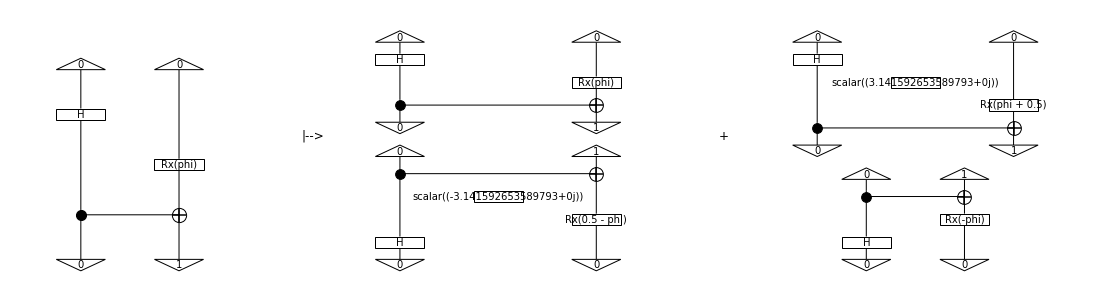

In [16]:
circuit = Ket(0, 0) >> H @ Rx(phi) >> CX >> Bra(0, 1)
gradient = (circuit >> circuit[::-1]).grad(phi, mixed=False)
drawing.equation(circuit, gradient, symbol="|-->", figsize=(15, 4))

Text(0, 0.5, 'Gradient')

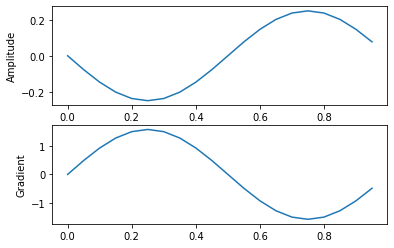

In [17]:
x = np.arange(0, 1, 0.05)
y = np.array([circuit.lambdify(phi)(i).eval(mixed=True).array.imag for i in x])
dy = np.array([gradient.lambdify(phi)(i).eval(mixed=False).array.real for i in x])
plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.ylabel("Amplitude")
plt.subplot(2, 1, 2)
plt.plot(x, dy)
plt.ylabel("Gradient")

## Bonus: Finding the exponent of a gate using Stone's theorem

A one-parameter unitary group is a unitary matrix $U: n \rightarrow n$ in $\operatorname{Mat}_{\mathrm{R} \rightarrow \mathrm{C}}$ with $U(0)=\mathrm{id}_{n}$ and $U(t) U(s)=U(s+t)$ for all $s, t \in \mathbb{R}$. It is strongly continuous when $\lim _{t \rightarrow t_{0}} U(t)=U\left(t_{0}\right)$ for all $t_{0} \in \mathbb{R}$ A one-parameter diagram $d: x^{\otimes n} \rightarrow x^{\otimes n}$ is said to be a unitary group when its interpretation $[[d]]$ is.

**Stone's Theorem**: There is a one-to-one correspondance between strongly continuous one-parameter unitary groups and self-adjoint matrices. The bijection is given explicitly by 
$$H \mapsto \exp (i t H)\quad \text{ and } \quad \mapsto-i(\partial U)(0)$$

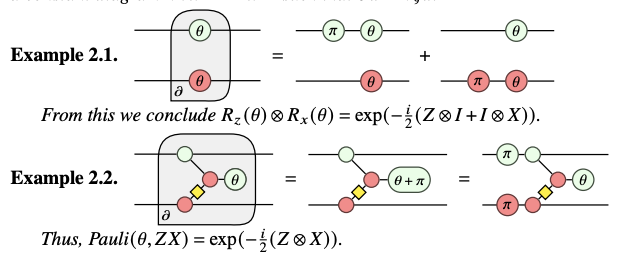

## Future Work

* completing discopy codebase for QML
* solving differential equations
* Keeping derivatives of ZX in ZX, rather than sum of ZX
* Formulate diag diff for Boolean circuits